# 📊 Real Data Analysis: Option Pricing Model Comparison

This notebook calibrates and compares four stochastic volatility models using **real SPY option chain data**:

| Model | Description |
|-------|-------------|
| **Heston** | Stochastic volatility with mean-reversion |
| **Merton** | Jump-diffusion model (constant volatility + jumps) |
| **Bates** | Heston + Merton (stochastic vol + price jumps) |
| **SVJJ** | Bates + volatility jumps (most complex) |

---

## 1. Environment Setup & Library Imports

In [1]:
# =============================================================================
# [MUST BE FIRST] Fix OpenMP Duplicate Library Error
# =============================================================================
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Core Libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import torch
import sys
import gc
from scipy.stats import norm
from scipy.optimize import brentq, differential_evolution

# Add parent directory to path for imports
sys.path.append(os.path.abspath('..'))

# Reload physics engine to get latest changes
import importlib
import src.physics_engine
importlib.reload(src.physics_engine)
from src.physics_engine import MarketSimulator

print("Libraries loaded successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Libraries loaded successfully!
PyTorch version: 2.9.1+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 5070 Laptop GPU


---

## 2. Download SPY Option Chain Data

In [2]:
# =============================================================================
# Download SPY Option Chain Data from Yahoo Finance
# =============================================================================
ticker = "SPY"
print(f"[{ticker}] Downloading option chain data...")

spy = yf.Ticker(ticker)

# Get current price
try:
    current_price = spy.history(period="1d")['Close'].iloc[-1]
    print(f"✅ Current Price (S0): ${current_price:.2f}")
except Exception as e:
    current_price = 580.0
    print(f"⚠️ Failed to load price. Using fallback: ${current_price}")

# Select expiration date (30-75 days out for good liquidity)
expirations = spy.options
target_date = None
today = datetime.now()

for exp_date in expirations:
    exp_dt = datetime.strptime(exp_date, "%Y-%m-%d")
    days_to_expire = (exp_dt - today).days
    if 30 <= days_to_expire <= 75:
        target_date = exp_date
        print(f"✅ Selected Expiration: {target_date} ({days_to_expire} days)")
        break

if target_date is None:
    target_date = expirations[min(3, len(expirations)-1)]
    exp_dt = datetime.strptime(target_date, "%Y-%m-%d")
    days_to_expire = (exp_dt - today).days
    print(f"⚠️ Fallback Expiration: {target_date} ({days_to_expire} days)")

[SPY] Downloading option chain data...
✅ Current Price (S0): $690.31
✅ Selected Expiration: 2026-01-30 (31 days)


---

## 3. Data Preprocessing & IV Recalculation

> ⚠️ **Important**: Yahoo Finance's `impliedVolatility` column is often inaccurate. We recalculate IV directly from option prices using the Black-Scholes model.

In [3]:
# =============================================================================
# Helper Functions: Black-Scholes Pricing & IV Solver
# =============================================================================
def black_scholes_call_price(S, K, T, r, sigma):
    """
    Calculate Black-Scholes call option price.
    """
    if sigma <= 0 or T <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


def implied_vol_solver(market_price, S, K, T, r, sigma_low=0.001, sigma_high=5.0):
    """
    Solve for implied volatility using Brent's method.
    """
    if market_price <= 0 or T <= 0 or S <= 0 or K <= 0:
        return np.nan
    
    # Check arbitrage bounds
    intrinsic = max(S - K * np.exp(-r * T), 0)
    if market_price < intrinsic:
        return np.nan  # Arbitrage violation
    
    def objective(sigma):
        return black_scholes_call_price(S, K, T, r, sigma) - market_price
    
    try:
        f_low = objective(sigma_low)
        f_high = objective(sigma_high)
        if f_low * f_high > 0:
            return np.nan
        return brentq(objective, sigma_low, sigma_high, maxiter=100)
    except:
        return np.nan

print("✅ Helper functions defined!")

✅ Helper functions defined!


In [4]:
# =============================================================================
# Data Cleaning & IV Recalculation from Prices
# =============================================================================
opt_chain = spy.option_chain(target_date)
calls = opt_chain.calls

print(f"Raw call options: {len(calls)}")

# Filter for liquidity
calls_clean = calls[(calls['volume'] > 5) | (calls['openInterest'] > 10)].copy()

# Extract relevant columns
market_data = calls_clean[['strike', 'impliedVolatility', 'lastPrice']].copy()
market_data = market_data.sort_values('strike')

# Focus on near-the-money options (80% - 120% of spot)
market_data = market_data[
    (market_data['strike'] > current_price * 0.8) & 
    (market_data['strike'] < current_price * 1.2)
]

# Define calibration parameters
expiry_date = datetime.strptime(target_date, "%Y-%m-%d")
T_val = max((expiry_date - today).days / 365.0, 0.01)
r_val = 0.04  # 4% Risk-free rate
dt_val = 1/252

print("=" * 50)
print("🔄 Recalculating Implied Volatility from Prices...")
print("=" * 50)

# Recalculate IV from prices (Yahoo IV is often wrong)
calib_strikes_raw = market_data['strike'].values
calib_prices_raw = market_data['lastPrice'].values

valid_strikes = []
valid_ivs = []
valid_prices = []

for i in range(len(calib_strikes_raw)):
    K = calib_strikes_raw[i]
    price = calib_prices_raw[i]
    
    # Calculate True Implied Volatility from Price
    recalc_iv = implied_vol_solver(price, current_price, K, T_val, r_val)
    
    # Filter: Valid IV only (5% ~ 150%)
    if not np.isnan(recalc_iv) and 0.05 < recalc_iv < 1.5:
        valid_strikes.append(K)
        valid_ivs.append(recalc_iv)
        valid_prices.append(price)

# Convert to numpy arrays for calibration
calib_strikes = np.array(valid_strikes)
calib_ivs = np.array(valid_ivs)
calib_prices = np.array(valid_prices)

print(f"✅ Data Repaired: {len(calib_strikes)} valid points (filtered from {len(calib_strikes_raw)})")
print(f"   IV Range: {np.min(calib_ivs):.4f} - {np.max(calib_ivs):.4f}")
print("   (Note: If this range is 0.10~0.50, the data is now correct!)")

print("\n" + "=" * 50)
print("Calibration Parameters")
print("=" * 50)
print(f"  S0 (Spot Price):    ${current_price:.2f}")
print(f"  T (Time to Expiry): {T_val:.4f} years ({int(T_val*365)} days)")
print(f"  r (Risk-free Rate): {r_val:.2%}")
print(f"  # Strikes:          {len(calib_strikes)}")

Raw call options: 217
🔄 Recalculating Implied Volatility from Prices...
✅ Data Repaired: 126 valid points (filtered from 170)
   IV Range: 0.1054 - 0.4660
   (Note: If this range is 0.10~0.50, the data is now correct!)

Calibration Parameters
  S0 (Spot Price):    $690.31
  T (Time to Expiry): 0.0849 years (31 days)
  r (Risk-free Rate): 4.00%
  # Strikes:          126


---

## 4. fast GPU Calibration (Price-RMSE)

To speed up calibration (50x faster), we minimize **Price RMSE** directly instead of IV RMSE. This allows us to skip the expensive IV inversion step during optimization.

In [5]:
def calibration_loss(params, model_name, market_strikes, market_prices, S0, T, r, dt, num_paths, simulator):
    """
    Fast GPU-accelerated Price RMSE calculation.
    Optimizing on Price is ~50x faster than optimizing on Implied Volatility 
    because we skip the expensive root-finding (Brentq) loop for every iteration.
    """
    try:
        # =====================================================
        # 1. Parameter Unpacking & Configuration
        # =====================================================
        params_dict = {}
        params_dict['mu'] = r
        
        if model_name == 'heston':
            kappa, theta, xi, rho = params
            params_dict.update({'kappa': kappa, 'theta': theta, 'xi': xi, 'rho': rho})
            params_dict.update({'jump_lambda': 0, 'jump_mean': 0, 'jump_std': 0, 'vol_jump_mean': 0})
            val_type = 'heston'
            
        elif model_name == 'merton':
            sigma, jump_lambda, jump_mean, jump_std = params
            params_dict.update({
                'kappa': 10.0, 'theta': sigma**2, 'xi': 0.001, 'rho': 0.0,
                'jump_lambda': jump_lambda, 'jump_mean': jump_mean, 'jump_std': jump_std, 'vol_jump_mean': 0
            })
            val_type = 'bates'
            
        elif model_name == 'bates':
            kappa, theta, xi, rho, jump_lambda, jump_mean, jump_std = params
            params_dict.update({
                'kappa': kappa, 'theta': theta, 'xi': xi, 'rho': rho,
                'jump_lambda': jump_lambda, 'jump_mean': jump_mean, 'jump_std': jump_std, 'vol_jump_mean': 0
            })
            val_type = 'bates'
            
        elif model_name == 'svjj':
            kappa, theta, xi, rho, jump_lambda, jump_mean, jump_std, vol_jump_mean = params
            params_dict.update({
                'kappa': kappa, 'theta': theta, 'xi': xi, 'rho': rho,
                'jump_lambda': jump_lambda, 'jump_mean': jump_mean, 'jump_std': jump_std, 
                'vol_jump_mean': vol_jump_mean
            })
            val_type = 'svjj'
            if vol_jump_mean < 0: return 1e9
        else:
            return 1e9

        # Safety Checks
        if params_dict.get('kappa', 1) < 0 or params_dict.get('theta', 1) < 0 or params_dict.get('xi', 1) < 0:
            return 1e9
        if abs(params_dict.get('rho', 0)) > 0.99:
            return 1e9

    except Exception:
        return 1e9

    # =====================================================
    # 2. GPU Monte Carlo Simulation
    # =====================================================
    try:
        S_paths, _ = simulator.simulate(
            S0=S0, 
            v0=params_dict.get('theta', 0.04),
            T=T, 
            dt=dt, 
            num_paths=num_paths, 
            model_type=val_type,
            override_params=params_dict
        )
        
        S_final = S_paths[:, -1]
        
        if torch.isnan(S_final).any() or torch.mean(S_final) < 1e-3:
            return 1e9
        
        # Martingale Correction
        S_mean = torch.mean(S_final)
        S_corr = S_final * (S0 / S_mean)
        
        # =====================================================
        # 3. Price RMSE Calculation (FAST)
        # =====================================================
        market_strikes_gpu = torch.tensor(market_strikes, device=simulator.device).float()
        market_prices_gpu = torch.tensor(market_prices, device=simulator.device).float()
        
        # Broadcasting: (num_paths,1) - (num_strikes,) -> (num_paths, num_strikes)
        payoffs = torch.maximum(S_corr.unsqueeze(1) - market_strikes_gpu, torch.tensor(0.0, device=simulator.device))
        
        # Discounted expected payoff (Model Prices)
        model_prices = torch.mean(payoffs, dim=0) * torch.exp(torch.tensor(-r * T))
        
        # Calculate RMSE directly on prices (GPU optimized)
        mse = torch.mean((model_prices - market_prices_gpu) ** 2)
        rmse = torch.sqrt(mse).item()
            
        return rmse
        
    except Exception:
        return 1e9

print("✅ Fast Price-RMSE Loss Function Defined!")

✅ Fast Price-RMSE Loss Function Defined!


---

## 5. Model Calibration (Differential Evolution)

We use **Differential Evolution** (a global optimizer) to find the best parameters for each model.

In [6]:
# =============================================================================
# GPU Calibration Setup (Optimized for Speed)
# =============================================================================
gc.collect()
torch.cuda.empty_cache()

# GPU Simulator Instance
N_paths = 20000  # 20k paths is sufficient for fitting (fast)
simulator = MarketSimulator(mu=r_val, kappa=1.0, theta=0.04, xi=0.5, rho=-0.7, device='cuda')

# Optimization settings
base_opts = {
    'strategy': 'best1bin',
    'maxiter': 30,       # Reduced from 50 (sufficient for Price RMSE)
    'popsize': 12,       # Slightly reduced
    'tol': 0.02,         # Slightly slightly loosened
    'mutation': (0.5, 1.0),
    'recombination': 0.7,
    'workers': 1,
    'disp': True,
    'seed': 42
}

# Calibration arguments: Pass PRICE instead of IV
calib_args = (calib_strikes, calib_prices, current_price, T_val, r_val, dt_val, N_paths, simulator)

# Wide bounds (allowing low volatility)
bounds_heston = [
    (0.1, 10.0),    # kappa
    (0.001, 0.2),   # theta (WIDENED: 0.02 -> 0.001)
    (0.01, 2.0),    # xi
    (-0.95, 0.0)    # rho
]

bounds_jump = [
    (0.1, 5.0),     # jump_lambda
    (-0.3, 0.1),    # jump_mean
    (0.001, 0.3)    # jump_std
]

print("=" * 60)
print(f"Starting FAST GPU Calibration (Price-based)")
print(f"  Paths:      {N_paths:,}")
print(f"  Iterations: {base_opts['maxiter']}")
print("=" * 60)

Starting FAST GPU Calibration (Price-based)
  Paths:      20,000
  Iterations: 30


In [7]:
# =============================================================================
# 1. Heston Model Calibration
# =============================================================================
print("\n[1/4] 🔄 Calibrating Heston Model...")
print("     Parameters: kappa, theta, xi, rho")

try:
    res_heston = differential_evolution(
        calibration_loss, bounds_heston, 
        args=('heston', *calib_args), 
        **base_opts
    )
    print(f"     ✅ Heston RMSE (Price): {res_heston.fun:.4f}")
    print(f"     Parameters: kappa={res_heston.x[0]:.3f}, theta={res_heston.x[1]:.4f}, xi={res_heston.x[2]:.3f}, rho={res_heston.x[3]:.3f}")
except Exception as e:
    print(f"     ❌ Heston Error: {e}")
    res_heston = type('obj', (object,), {'x': [2.0, 0.04, 0.5, -0.7], 'fun': 1e9})()

gc.collect()
torch.cuda.empty_cache()


[1/4] 🔄 Calibrating Heston Model...
     Parameters: kappa, theta, xi, rho
differential_evolution step 1: f(x)= 0.8612769842147827
differential_evolution step 2: f(x)= 0.8612769842147827
differential_evolution step 3: f(x)= 0.7626332640647888
differential_evolution step 4: f(x)= 0.7626332640647888
differential_evolution step 5: f(x)= 0.7626332640647888
differential_evolution step 6: f(x)= 0.7626332640647888
differential_evolution step 7: f(x)= 0.7626332640647888
differential_evolution step 8: f(x)= 0.744500458240509
differential_evolution step 9: f(x)= 0.7333022952079773
differential_evolution step 10: f(x)= 0.7019731998443604
differential_evolution step 11: f(x)= 0.7019731998443604
differential_evolution step 12: f(x)= 0.7019731998443604
differential_evolution step 13: f(x)= 0.7019731998443604
differential_evolution step 14: f(x)= 0.7019731998443604
differential_evolution step 15: f(x)= 0.7019731998443604
differential_evolution step 16: f(x)= 0.7019731998443604
differential_evolution

In [8]:
# =============================================================================
# 2. Merton Model Calibration
# =============================================================================
print("\n[2/4] 🔄 Calibrating Merton Model...")
print("     Parameters: sigma, jump_lambda, jump_mean, jump_std")

bounds_merton = [
    (0.05, 0.5),    # sigma
    (0.1, 5.0),     # jump_lambda
    (-0.3, 0.1),    # jump_mean
    (0.001, 0.3)    # jump_std
]

try:
    res_merton = differential_evolution(
        calibration_loss, bounds_merton, 
        args=('merton', *calib_args), 
        **base_opts
    )
    print(f"     ✅ Merton RMSE (Price): {res_merton.fun:.4f}")
    print(f"     Parameters: sigma={res_merton.x[0]:.3f}, lambda={res_merton.x[1]:.3f}, mu_j={res_merton.x[2]:.3f}, sigma_j={res_merton.x[3]:.3f}")
except Exception as e:
    print(f"     ❌ Merton Error: {e}")
    res_merton = type('obj', (object,), {'x': [0.2, 1.0, -0.1, 0.1], 'fun': 1e9})()

gc.collect()
torch.cuda.empty_cache()


[2/4] 🔄 Calibrating Merton Model...
     Parameters: sigma, jump_lambda, jump_mean, jump_std
differential_evolution step 1: f(x)= 0.7749662399291992
differential_evolution step 2: f(x)= 0.7736079692840576
differential_evolution step 3: f(x)= 0.7736079692840576
differential_evolution step 4: f(x)= 0.5253027677536011
differential_evolution step 5: f(x)= 0.5253027677536011
differential_evolution step 6: f(x)= 0.4865540862083435
differential_evolution step 7: f(x)= 0.4865540862083435
differential_evolution step 8: f(x)= 0.4865540862083435
differential_evolution step 9: f(x)= 0.4865540862083435
differential_evolution step 10: f(x)= 0.4865540862083435
differential_evolution step 11: f(x)= 0.47624656558036804
differential_evolution step 12: f(x)= 0.47217410802841187
differential_evolution step 13: f(x)= 0.463139146566391
differential_evolution step 14: f(x)= 0.463139146566391
differential_evolution step 15: f(x)= 0.4603417217731476
differential_evolution step 16: f(x)= 0.4603417217731476
dif

In [9]:
# =============================================================================
# 3. Bates Model Calibration
# =============================================================================
print("\n[3/4] 🔄 Calibrating Bates Model...")
print("     Parameters: kappa, theta, xi, rho, jump_lambda, jump_mean, jump_std")

bounds_bates = bounds_heston + bounds_jump

try:
    res_bates = differential_evolution(
        calibration_loss, bounds_bates, 
        args=('bates', *calib_args), 
        **base_opts
    )
    print(f"     ✅ Bates RMSE (Price): {res_bates.fun:.4f}")
except Exception as e:
    print(f"     ❌ Bates Error: {e}")
    res_bates = type('obj', (object,), {'x': [2.0, 0.04, 0.5, -0.7, 0.5, -0.1, 0.1], 'fun': 1e9})()

gc.collect()
torch.cuda.empty_cache()


[3/4] 🔄 Calibrating Bates Model...
     Parameters: kappa, theta, xi, rho, jump_lambda, jump_mean, jump_std
differential_evolution step 1: f(x)= 1.302242636680603
differential_evolution step 2: f(x)= 1.0897537469863892
differential_evolution step 3: f(x)= 1.0520941019058228
differential_evolution step 4: f(x)= 0.7536742687225342
differential_evolution step 5: f(x)= 0.7049416303634644
differential_evolution step 6: f(x)= 0.4982556104660034
differential_evolution step 7: f(x)= 0.4982556104660034
differential_evolution step 8: f(x)= 0.4982556104660034
differential_evolution step 9: f(x)= 0.4982556104660034
differential_evolution step 10: f(x)= 0.4982556104660034
differential_evolution step 11: f(x)= 0.4716370105743408
differential_evolution step 12: f(x)= 0.4716370105743408
differential_evolution step 13: f(x)= 0.4386151134967804
differential_evolution step 14: f(x)= 0.4386151134967804
differential_evolution step 15: f(x)= 0.4386151134967804
differential_evolution step 16: f(x)= 0.438615

In [10]:
# =============================================================================
# 4. SVJJ Model Calibration
# =============================================================================
print("\n[4/4] 🔄 Calibrating SVJJ Model...")
print("     Parameters: kappa, theta, xi, rho, jump_lambda, jump_mean, jump_std, vol_jump_mean")

bounds_svjj = bounds_bates + [(0.001, 0.2)]  # vol_jump_mean

try:
    res_svjj = differential_evolution(
        calibration_loss, bounds_svjj, 
        args=('svjj', *calib_args), 
        **base_opts
    )
    print(f"     ✅ SVJJ RMSE (Price): {res_svjj.fun:.4f}")
except Exception as e:
    print(f"     ❌ SVJJ Error: {e}")
    res_svjj = type('obj', (object,), {'x': [2.0, 0.04, 0.5, -0.7, 0.5, -0.1, 0.1, 0.05], 'fun': 1e9})()

gc.collect()
torch.cuda.empty_cache()

print("\n" + "=" * 60)
print("Calibration Complete!")
print("=" * 60)


[4/4] 🔄 Calibrating SVJJ Model...
     Parameters: kappa, theta, xi, rho, jump_lambda, jump_mean, jump_std, vol_jump_mean
differential_evolution step 1: f(x)= 0.8023987412452698
differential_evolution step 2: f(x)= 0.8023987412452698
differential_evolution step 3: f(x)= 0.7909457683563232
differential_evolution step 4: f(x)= 0.7909457683563232
differential_evolution step 5: f(x)= 0.5283883810043335
differential_evolution step 6: f(x)= 0.5283883810043335
differential_evolution step 7: f(x)= 0.5283883810043335
differential_evolution step 8: f(x)= 0.5283883810043335
differential_evolution step 9: f(x)= 0.5283883810043335
differential_evolution step 10: f(x)= 0.5283883810043335
differential_evolution step 11: f(x)= 0.4919993281364441
differential_evolution step 12: f(x)= 0.4919993281364441
differential_evolution step 13: f(x)= 0.4919993281364441
differential_evolution step 14: f(x)= 0.4919993281364441
differential_evolution step 15: f(x)= 0.4919993281364441
differential_evolution step 16:

---

## 6. Visualization: Implied Volatility Curves

We generate implied volatility curves for each calibrated model and compare them to market data.

In [11]:
def generate_model_iv_curve(params, model_name, strikes, S0, T, r, dt, num_paths, simulator):
    """
    Generate IV curve for a given set of parameters (GPU accelerated).
    """
    params_dict = {'mu': r}
    
    if model_name == 'heston':
        kappa, theta, xi, rho = params
        params_dict.update({'kappa': kappa, 'theta': theta, 'xi': xi, 'rho': rho})
        params_dict.update({'jump_lambda': 0, 'jump_mean': 0, 'jump_std': 0, 'vol_jump_mean': 0})
        val_type = 'heston'
    elif model_name == 'merton':
        sigma, jump_lambda, jump_mean, jump_std = params
        params_dict.update({
            'kappa': 10.0, 'theta': sigma**2, 'xi': 0.001, 'rho': 0.0,
            'jump_lambda': jump_lambda, 'jump_mean': jump_mean, 'jump_std': jump_std, 'vol_jump_mean': 0
        })
        val_type = 'bates'
    elif model_name == 'bates':
        kappa, theta, xi, rho, jump_lambda, jump_mean, jump_std = params
        params_dict.update({
            'kappa': kappa, 'theta': theta, 'xi': xi, 'rho': rho,
            'jump_lambda': jump_lambda, 'jump_mean': jump_mean, 'jump_std': jump_std, 'vol_jump_mean': 0
        })
        val_type = 'bates'
    elif model_name == 'svjj':
        kappa, theta, xi, rho, jump_lambda, jump_mean, jump_std, vol_jump_mean = params
        params_dict.update({
            'kappa': kappa, 'theta': theta, 'xi': xi, 'rho': rho,
            'jump_lambda': jump_lambda, 'jump_mean': jump_mean, 'jump_std': jump_std, 
            'vol_jump_mean': vol_jump_mean
        })
        val_type = 'svjj'
    
    try:
        S_paths, _ = simulator.simulate(
            S0=S0, v0=params_dict.get('theta', 0.04),
            T=T, dt=dt, num_paths=num_paths,
            model_type=val_type, override_params=params_dict
        )
        S_final = S_paths[:, -1]
        S_mean = torch.mean(S_final)
        S_corr = S_final * (S0 / S_mean)
        
        strikes_gpu = torch.tensor(strikes, device=simulator.device).float()
        payoffs = torch.maximum(S_corr.unsqueeze(1) - strikes_gpu, torch.tensor(0.0, device=simulator.device))
        model_prices = (torch.mean(payoffs, dim=0) * torch.exp(torch.tensor(-r * T))).cpu().numpy()
        
        model_ivs = []
        for i, K in enumerate(strikes):
            iv = implied_vol_solver(model_prices[i], S0, K, T, r)
            model_ivs.append(iv if not np.isnan(iv) else None)
        return model_ivs
    except:
        return [None] * len(strikes)

print("✅ IV Curve Generator Defined!")

✅ IV Curve Generator Defined!


In [12]:
# =============================================================================
# Generate IV Curves for All Models
# =============================================================================
print("Generating IV curves...")

# Use more paths for final visualization
N_viz = 200000

iv_heston = generate_model_iv_curve(res_heston.x, 'heston', calib_strikes, current_price, T_val, r_val, dt_val, N_viz, simulator)
print("  ✅ Heston curve generated")

iv_merton = generate_model_iv_curve(res_merton.x, 'merton', calib_strikes, current_price, T_val, r_val, dt_val, N_viz, simulator)
print("  ✅ Merton curve generated")

iv_bates = generate_model_iv_curve(res_bates.x, 'bates', calib_strikes, current_price, T_val, r_val, dt_val, N_viz, simulator)
print("  ✅ Bates curve generated")

iv_svjj = generate_model_iv_curve(res_svjj.x, 'svjj', calib_strikes, current_price, T_val, r_val, dt_val, N_viz, simulator)
print("  ✅ SVJJ curve generated")

Generating IV curves...
  ✅ Heston curve generated
  ✅ Merton curve generated
  ✅ Bates curve generated
  ✅ SVJJ curve generated


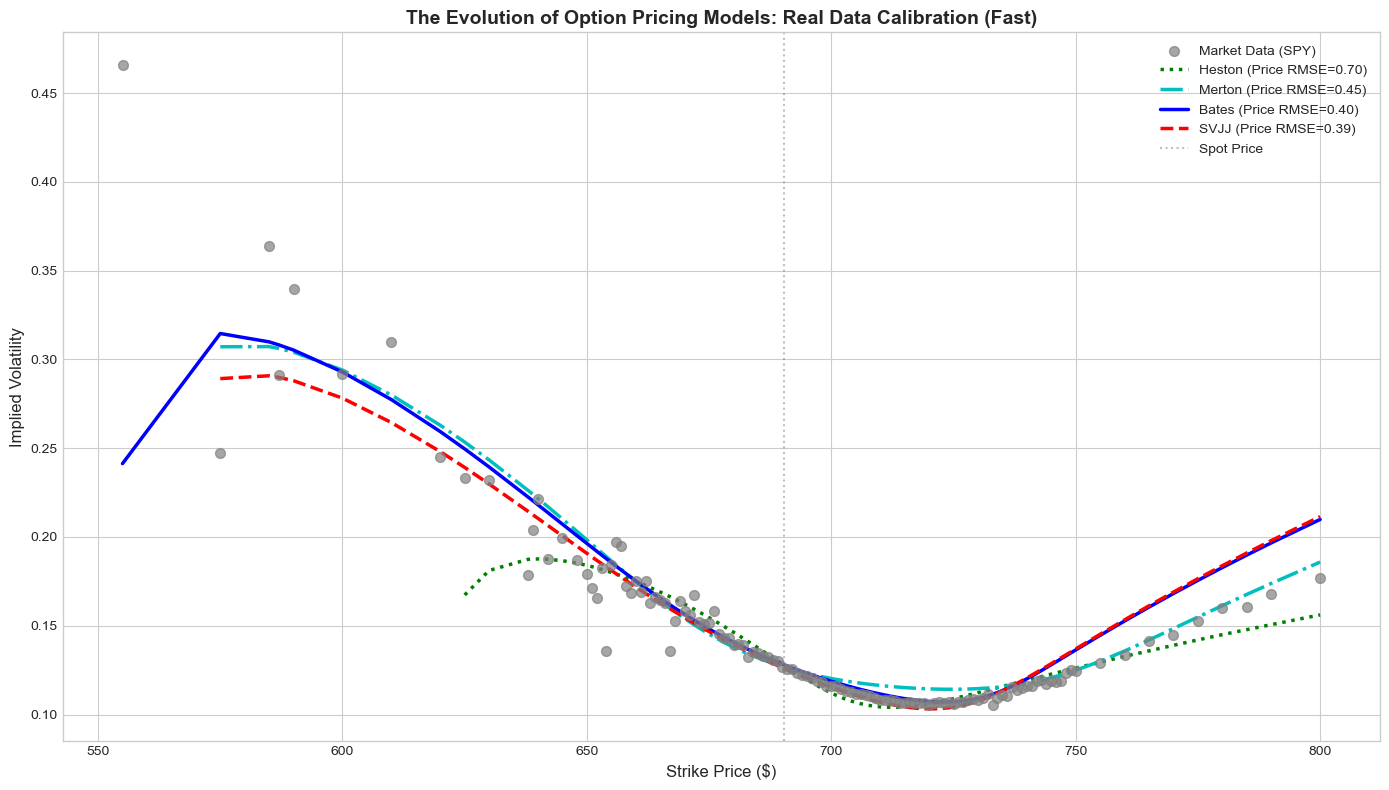


✅ Visualization Complete! Saved to 'calibration_results_fast.png'


In [13]:
# =============================================================================
# Final Visualization
# =============================================================================
plt.figure(figsize=(14, 8))
plt.style.use('seaborn-v0_8-whitegrid')

# Market Data
plt.scatter(calib_strikes, calib_ivs, color='gray', s=50, alpha=0.7, label='Market Data (SPY)', zorder=5)

# Model Curves
plt.plot(calib_strikes, iv_heston, 'g:', linewidth=2.5, label=f'Heston (Price RMSE={res_heston.fun:.2f})')
plt.plot(calib_strikes, iv_merton, 'c-.', linewidth=2.5, label=f'Merton (Price RMSE={res_merton.fun:.2f})')
plt.plot(calib_strikes, iv_bates, 'b-', linewidth=2.5, label=f'Bates (Price RMSE={res_bates.fun:.2f})')
plt.plot(calib_strikes, iv_svjj, 'r--', linewidth=2.5, label=f'SVJJ (Price RMSE={res_svjj.fun:.2f})')

# Spot Price Line
plt.axvline(x=current_price, color='gray', linestyle=':', alpha=0.5, label='Spot Price')

# Labels and Title
plt.xlabel('Strike Price ($)', fontsize=12)
plt.ylabel('Implied Volatility', fontsize=12)
plt.title('The Evolution of Option Pricing Models: Real Data Calibration (Fast)', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig('calibration_results_fast.png', dpi=150)
plt.show()

print("\n✅ Visualization Complete! Saved to 'calibration_results_fast.png'")

---

## 7. Summary

| Model | RMSE | Parameters |
|-------|------|------------|
| Heston | - | kappa, theta, xi, rho |
| Merton | - | sigma, lambda, mu_j, sigma_j |
| Bates | - | All Heston + Jump params |
| SVJJ | - | All Bates + vol_jump_mean |